# Initialize

In [1]:
from ops.imports_ipython import *
import glob

In [ ]:
os.chdir('20200206_6W-LaC025A/')

# combine tables

In [4]:
ops.utils.combine_tables('cp_phenotype',output_filetype='hdf',subdir='process_ph/tables',n_jobs=-2,
    usecols=[
        'well','tile','cell',
        'i','j','bounds_0','bounds_1','bounds_2','bounds_3',
        # to identify cells on an acquisition border
        'cell_dapi_min','cell_tubulin_min','cell_gh2ax_min','cell_phalloidin_min'
        ]
)
os.rename('cp_phenotype.hdf','min_cp_phenotype.hdf')

In [5]:
ops.utils.combine_tables('merge',output_filetype='hdf',subdir='alignment',n_jobs=-2)

In [ ]:
ops.utils.combine_tables('cells',output_filetype='hdf',subdir='process_sbs/tables',n_jobs=-2)

In [7]:
df_merged = pd.read_hdf('merge.hdf')

# add distance to FOV center for each cell

In [8]:
def fov_distance(df,i='i',j='j',dimensions=(2960,2960),suffix=''):
    distance  = lambda x: np.sqrt((x[i]-(dimensions[0]/2))**2+(x[j]-(dimensions[1]/2))**2)
    df['fov_distance'+suffix]=df.apply(distance,axis=1)
    return df

In [9]:
df_merged.pipe(fov_distance,i='i_0',j='j_0',suffix='_0');

In [10]:
df_merged.pipe(fov_distance,i='i_1',j='j_1',dimensions=(1480,1480),suffix='_1');

In [11]:
df_merged.sort_values(['fov_distance_1']).head()

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1
637,A3,381,670,1424.945989,1527.332804,113,2676,739.878049,740.048780,0.008756,72.603984,0.131345
628,B1,956,661,1504.350401,1467.119062,247,2477,739.858491,739.792453,0.312899,27.547424,0.251199
691,B1,116,727,1405.540948,1507.139009,38,3037,739.666667,739.886179,0.102555,79.250717,0.352231
566,A2,964,599,1497.744681,1420.606915,251,2161,739.681416,740.327434,0.247624,61.987194,0.456846
817,B1,1043,862,1513.355296,1397.364470,257,3197,739.544304,739.949367,0.211759,89.113448,0.458501


# add mapping info

In [12]:
df_cells = pd.read_hdf('cells.hdf')

In [13]:
df_cells.head()

,cell,tile,well,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,...,cell_barcode_count_0,cell_barcode_1,cell_barcode_count_1,barcode_count,sgRNA_0,gene_symbol_0,group_0,sgRNA_1,gene_symbol_1,group_1
0,26,166,B3,0.631905,0.522037,0.488358,0.984964,0.994270,0.427040,0.694546,...,1,NaN,0.0,1,CAGTGATAAATCGGACAATG,AMHR2,essentials_11L2,NaN,NaN,NaN
1,37,166,B3,1.000000,0.701304,0.913596,0.679438,0.572583,1.000000,1.000000,...,3,NaN,0.0,3,GCTTTGATACCACTCGGCAG,SGCA,essentials_11L2,NaN,NaN,NaN
2,39,166,B3,0.811780,1.000000,0.825922,0.489259,0.623988,0.903161,0.721672,...,1,NaN,0.0,1,GATGTAGGACCCTATGAGTG,CEACAM5,essentials_11L2,NaN,NaN,NaN
3,40,166,B3,0.982708,1.000000,0.512501,0.471184,1.000000,0.447563,0.301265,...,3,NaN,0.0,3,CAGTCTGTTCTGATAACCTG,CDC20,essentials_11L2,NaN,NaN,NaN
4,43,166,B3,0.040829,0.507211,0.650830,0.583170,0.483280,0.711397,1.000000,...,1,AATCCCCCACC,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_cells['mapped_single_gene'] = (df_cells.apply(lambda x: True 
                    if (pd.notnull(x.gene_symbol_0)&pd.isnull(x.gene_symbol_1))|(x.gene_symbol_0==x.gene_symbol_1) 
                    else False,axis=1)
                                  )

In [15]:
df_cells.mapped_single_gene.value_counts()

True     5157949
False    2304353
Name: mapped_single_gene, dtype: int64

In [16]:
df_merged = df_merged.merge((df_cells[['well','tile','cell','sgRNA_0','gene_symbol_0','group_0','mapped_single_gene']]
                             .rename({'tile':'site','cell':'cell_1'},axis=1)),
                            how='left',on=['well','site','cell_1'])

In [17]:
df_merged.head(10).sort_values(['mapped_single_gene','fov_distance_1'],ascending=[False,True])

,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,distance,fov_distance_0,fov_distance_1,sgRNA_0,gene_symbol_0,group_0,mapped_single_gene
2,B1,498,769,1470.339768,212.638514,134,393,105.353383,1076.563910,1.944252,1267.398303,718.367311,AGTAGGGCATCATGAGCGTG,SLC7A1,essentials_11L2,True
0,B1,498,708,1333.763373,11.970082,134,267,71.223022,1024.517986,1.972813,1475.295561,726.782726,GGCGCAGGGGACTACGGGAA,PABPN1,essentials_11L2,True
4,B1,498,782,1494.385263,449.729123,134,421,110.922222,1135.533333,1.988452,1030.371300,743.091830,CTAAGCAGCAAGTGTCAGGG,RPP38,essentials_11L2,True
1,B1,498,753,1443.259238,497.957852,134,370,98.258929,1147.669643,1.903856,982.729191,760.280304,TAAACTCCATCTCTCACCAT,ADSS2,essentials_11L2,True
3,B1,498,777,1491.348015,109.851404,134,420,110.854962,1050.977099,1.956748,1370.195589,701.804984,AGTAGGGCATCATGAGCGTG,SLC7A1,essentials_11L2,False
6,B1,498,791,1518.478968,374.012900,134,446,117.616667,1116.933333,1.494526,1106.656269,727.626107,ACTTCATGGGAAGATAGCTG,PPAT,essentials_11L2,False
5,B1,498,788,1511.105058,507.276265,134,438,115.500000,1149.700000,1.535801,973.220936,746.896472,NaN,NaN,NaN,False
7,B1,498,796,1521.071704,588.368142,134,449,117.618705,1170.179856,1.858076,892.577310,756.579926,CATTAACATCATCATCCAGT,HNRNPCL1,essentials_11L2,False
8,B1,498,801,1529.677560,179.905229,134,457,120.350427,1068.350427,1.795719,1301.043533,701.269988,NaN,NaN,NaN,NaN
9,B1,498,809,1542.794973,533.651218,134,469,123.056180,1156.303371,1.855150,948.429874,744.263511,NaN,NaN,NaN,NaN


# add phenotype min info

In [18]:
df_phenotype = pd.read_hdf('min_cp_phenotype.hdf').fillna(0)

In [19]:
min_cols = [col for col in df_phenotype.columns if '_min' in col]
info_cols = [col for col in df_phenotype.columns if col not in min_cols]

In [21]:
df_phenotype['channels_min'] = df_phenotype[min_cols].apply(lambda x: x.min(axis=0),axis=1)

In [23]:
df_merged = df_merged.merge((df_phenotype[['well','tile','cell','channels_min']]
                             .rename(columns={'cell':'cell_0'})),
                            how='left',on=['well','tile','cell_0'])

In [8]:
misaligned = np.array([['B3',471],['B3',572]])
misaligned_wells = list(misaligned[:,0])
misaligned_tiles = list(misaligned[:,1])

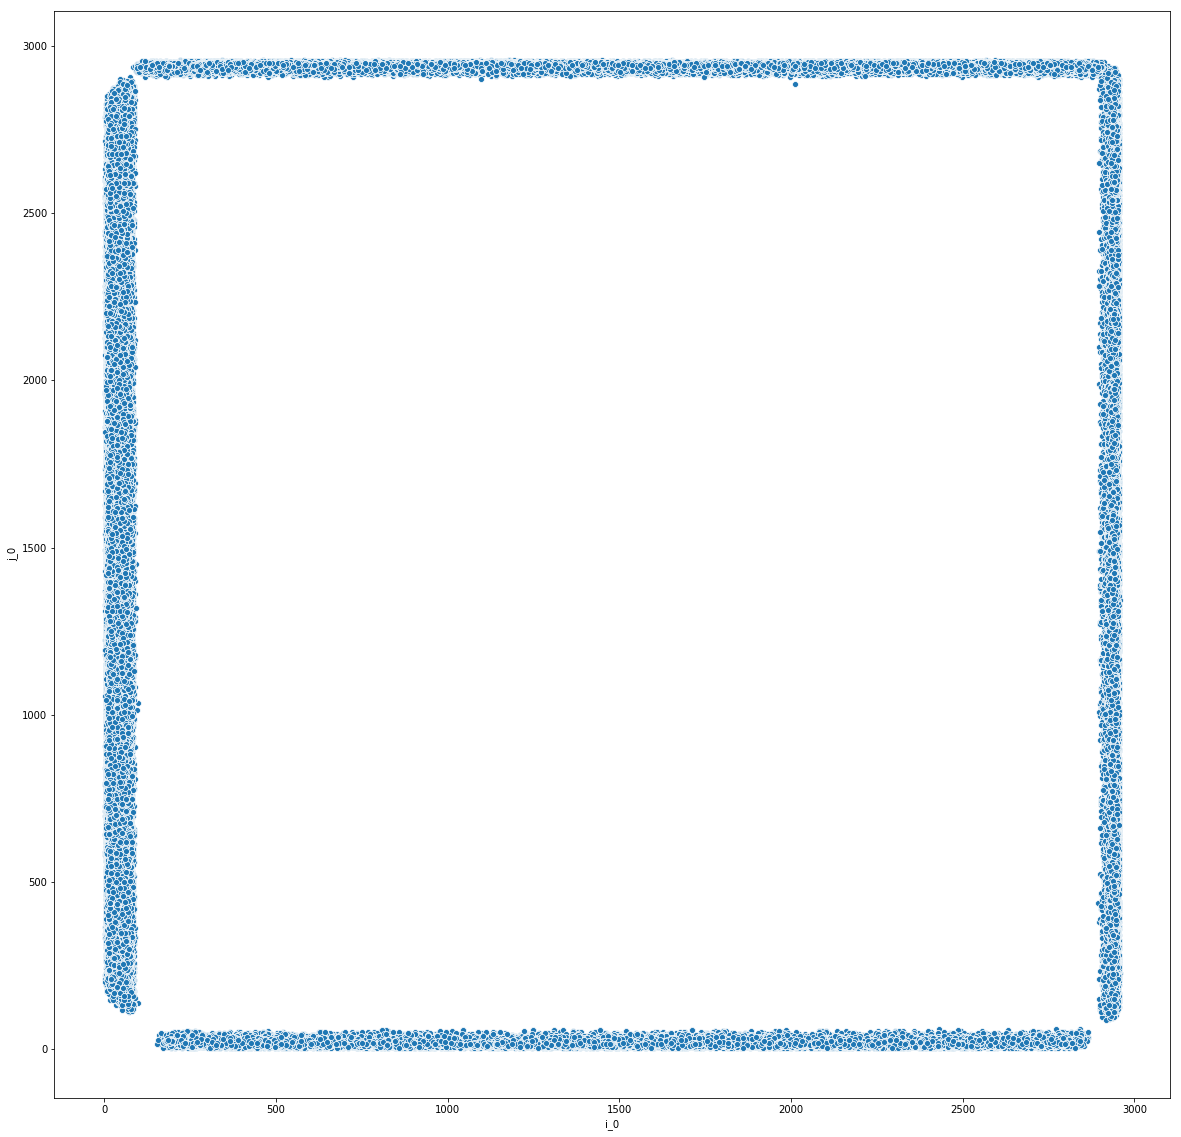

In [10]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=(df_merged
                      .query('channels_min==0')
                      .query('well != @misaligned_wells & tile != @misaligned_tiles')[['i_0','j_0']]
                     ),
                x='i_0',y='j_0')

# filter merged datasets for duplicates

In [11]:
df_merged.groupby(['well','tile']).cell_0.value_counts().value_counts()

1    7022631
2    2008050
3      37859
4       2307
Name: cell_0, dtype: int64

In [12]:
df_merged.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6559625
2    2035662
3      81265
4      71698
Name: cell_1, dtype: int64

In [13]:
df_merged.drop_duplicates(['well','site','cell_1']).pipe(len)

8748250

In [14]:
df_merged.pipe(len)

11161536

In [80]:
# remove bad tiles and cells with phenotype channel min ==0
df_merged_ph = (df_merged
                .query('well != @misaligned_wells | tile != @misaligned_tiles')
#              .query('well != "B3" | tile != 471')
#              .query('well != "B3" | tile != 572')
             .query('channels_min>0')
            )

In [81]:
df_merged_ph.drop_duplicates(['well','site','cell_1']).pipe(len)

8725056

In [82]:
df_merged_ph.groupby(['well','site']).cell_1.value_counts().value_counts()

1    6853247
2    1759912
4      56048
3      55849
Name: cell_1, dtype: int64

In [84]:
# drop sbs cells mapping to same phenotype cell by priority (mapping, fov_distance)
df_merged_filt = (df_merged_ph
                  .sort_values(['mapped_single_gene','fov_distance_1'],
                               ascending=[False,True])
                  .drop_duplicates(['well','tile','cell_0'],keep='first')
                 )

In [86]:
df_merged_filt.groupby(['well','site']).cell_1.value_counts().value_counts()

1    5287014
2    1516890
4      56048
3      55849
Name: cell_1, dtype: int64

In [87]:
# drop duplicated phenotype cells mapping to same sbs cell by priority (fov_distance)
df_merged_filt_filt = (df_merged_filt
                       .sort_values(['fov_distance_0'],ascending=True)
                       .drop_duplicates(['well','site','cell_1'],keep='first')
                      )

In [88]:
df_merged_filt_filt.pipe(len)

6915801

In [89]:
df_merged_filt_filt[df_merged_filt_filt.mapped_single_gene==True].pipe(len)

3935729

In [ ]:
df_merged.to_hdf('merge.hdf', 'x', mode='w')

In [ ]:
df_merged_filt_filt.to_hdf('merged_deduped.hdf', 'x', mode='w')

# check cell matching rate

In [31]:
df_sbs_info = pd.concat([pd.read_hdf(f) for f in glob.glob('sbs_info_*.hdf')])

In [32]:
df_sbs_info.to_hdf('sbs_info.hdf','x',mode='w')

In [33]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_1','tile':'site'}

#before deduping, how many sbs cells map to a phenotype cell
df_sbs_matching = (df_sbs_info
                   .rename(columns=cols_1)
                   .drop(columns=['i','j'])
                   .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','site','cell_1'])
                  )

In [34]:
# before deduping
for well,df in df_sbs_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 90.08245906542125%
For well A2, cell matching rate is 90.73231742211053%
For well A3, cell matching rate is 90.52088481595588%
For well B1, cell matching rate is 90.26282673768574%
For well B2, cell matching rate is 90.88465674602301%
For well B3, cell matching rate is 90.55043841295384%


In [35]:
del df_sbs_matching

In [36]:
del df_sbs_info

In [37]:
df_ph_info = pd.concat([pd.read_hdf(f) for f in glob.glob('ph_info_*.hdf')])

In [38]:
df_ph_info.to_hdf('ph_info.hdf','x',mode='w')

In [39]:
# cols_0 = {'i':'i_0','j':'j_0','cell':'cell_0','tile':'tile_0'}
cols_1 = {'cell':'cell_0'}

#before deduping, how many sbs cells map to a phenotype cell
df_ph_matching = (df_ph_info
                 .rename(columns=cols_1)
                 .drop(columns=['i','j'])
                 .merge(df_merged,
#                         .rename(columns=cols_0),
                        how='left',on=['well','tile','cell_0'])
                )

In [94]:
for well,df in df_ph_matching.groupby('well'):
    all_cells = df.pipe(len)
    lonely_cells = df.distance.isnull().sum()
    mapping = (all_cells-lonely_cells)/all_cells
    print('For well '+well+', cell matching rate is '+str(mapping*100)+'%')

For well A1, cell matching rate is 93.75433396299242%
For well A2, cell matching rate is 94.23493170305035%
For well A3, cell matching rate is 94.17362513795473%
For well B1, cell matching rate is 94.1662083260279%
For well B2, cell matching rate is 94.55408166587975%
For well B3, cell matching rate is 94.25568349445653%


# add full phenotype, reduce to single mapping

In [ ]:
# this section unused?

In [95]:
import gc

In [96]:
df_merged_deduped = pd.read_hdf('merged_deduped.hdf')

In [97]:
df_merged_deduped = df_merged_deduped[df_merged_deduped['mapped_single_gene']==True]

In [98]:
df_merged_deduped.pipe(len)

3935729

In [99]:
df_phenotype = pd.read_hdf('simple_nuclear_phenotype.hdf')

In [100]:
gc.collect()

382

In [101]:
final_merge_cols = [col for col in df_merged_deduped.columns 
                    if 'distance' not in col 
                        and col != 'mapped_single_gene' 
                        and col != 'channels_min'
                   ]

In [102]:
final_merge_cols

['well',
 'tile',
 'cell_0',
 'i_0',
 'j_0',
 'site',
 'cell_1',
 'i_1',
 'j_1',
 'sgRNA_0',
 'gene_symbol_0',
 'group_0']

In [103]:
df_merged_deduped = df_merged_deduped[final_merge_cols]

In [104]:
final_ph_cols = [col for col in df_phenotype.columns 
                    if col not in ['i','j']
                   ]

In [105]:
df_phenotype = df_phenotype[final_ph_cols].rename(columns={'cell':'cell_0'})

In [106]:
df_phenotype.head()

,dapi_nuclear_min,dapi_nuclear_25,dapi_nuclear_mean,dapi_nuclear_median,dapi_nuclear_75,dapi_nuclear_max,dapi_nuclear_int,dapi_nuclear_sd,dapi_nuclear_mad,dm1a_nuclear_min,...,solidity_nuclear,extent_nuclear,area,cell_0,bounds_0,bounds_1,bounds_2,bounds_3,tile,well
0,746,1068.50,1221.887324,1223.0,1389.50,1668,433770,219.324517,164.0,0,...,0.889724,0.682692,355,1,0,345,13,385,115,B3
1,768,1216.25,1414.741996,1418.5,1663.00,2073,1502456,295.783086,229.0,0,...,0.922676,0.722449,1062,2,0,398,35,440,115,B3
2,1253,1517.50,1795.824847,1786.0,2047.50,2631,881750,323.720036,263.0,0,...,0.938815,0.663514,491,3,0,452,20,489,115,B3
3,1289,1705.25,1963.823988,1955.0,2239.50,2758,1260775,323.183177,266.0,0,...,0.961078,0.775362,642,4,0,549,18,595,115,B3
4,1032,2271.25,2621.751092,2718.5,3022.75,3860,1200762,592.362809,350.5,0,...,0.946281,0.726984,458,5,0,938,14,983,115,B3


In [107]:
df_merged_deduped_phenotype = df_merged_deduped.merge(df_phenotype,how='left',on=['well','tile','cell_0'])

In [108]:
df_merged_deduped_phenotype.pipe(len)

3935729

In [109]:
def remove_edge_cells(df):
    df['edge'] = df[['bounds_0','bounds_1','bounds_2','bounds_3']].apply(lambda x:( x.min(axis=0)==0)|(x.max(axis=0)==2960),axis=1)
    return df[df['edge'] != True].drop(columns='edge')


In [110]:
gb_cols = ['well','tile']

In [111]:
df_merged_deduped_phenotype = df_merged_deduped_phenotype.pipe(ops.utils.gb_apply_parallel,gb_cols,remove_edge_cells,n_jobs=-1)

In [112]:
df_merged_deduped_phenotype.pipe(len)

3934146

In [113]:
df_merged_deduped_phenotype.to_hdf('merged_deduped_phenotype.hdf','x',mode='w')

In [114]:
df_merged_deduped_phenotype.columns

Index(['well', 'tile', 'cell_0', 'i_0', 'j_0', 'site', 'cell_1', 'i_1', 'j_1',
       'sgRNA_0', 'gene_symbol_0', 'group_0', 'dapi_nuclear_min',
       'dapi_nuclear_25', 'dapi_nuclear_mean', 'dapi_nuclear_median',
       'dapi_nuclear_75', 'dapi_nuclear_max', 'dapi_nuclear_int',
       'dapi_nuclear_sd', 'dapi_nuclear_mad', 'dm1a_nuclear_min',
       'dm1a_nuclear_25', 'dm1a_nuclear_mean', 'dm1a_nuclear_median',
       'dm1a_nuclear_75', 'dm1a_nuclear_max', 'dm1a_nuclear_int',
       'dm1a_nuclear_sd', 'dm1a_nuclear_mad', 'gh2ax_nuclear_min',
       'gh2ax_nuclear_25', 'gh2ax_nuclear_mean', 'gh2ax_nuclear_median',
       'gh2ax_nuclear_75', 'gh2ax_nuclear_max', 'gh2ax_nuclear_int',
       'gh2ax_nuclear_sd', 'gh2ax_nuclear_mad', 'phalloidin_nuclear_min',
       'phalloidin_nuclear_25', 'phalloidin_nuclear_mean',
       'phalloidin_nuclear_median', 'phalloidin_nuclear_75',
       'phalloidin_nuclear_max', 'phalloidin_nuclear_int',
       'phalloidin_nuclear_sd', 'phalloidin_nuclear_mad